In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import libstempo as t2
from statsmodels.graphics import tsaplots

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

# 1 Generative model for residuals

The pulsar timing residuals are modeled as a sum of many different deterministic and stochastic terms. We write the full model for the pulse TOAs as

$$\tau = \tau^{\rm TM} + \tau^{\rm DM} + \tau^{\rm GW} + \tau^{\rm RN} + \tau^{\rm EC} + \tau^{\rm WN}$$

where 

* $\tau^{\rm TM}$: Physical model for TOAs taking in to account spin period, proper motion, binary orbital dynamics, etc.
* $\tau^{\rm DM}$: Model for time-varying dispersion measure variations (i.e. has $1/\nu^2$ dependence, where $\nu$ is the radio frequency)
* $\tau^{\rm GW}$: Model for any Gravitational Waves (GWs). This could include deterministic sources or stochastic sources.
* $\tau^{\rm RN}$: Model for red noise (i.e. low-frequency correlated noise). Could also be call autoregressive noise. Correlation timscales on the order of weeks - years
* $\tau^{\rm EC}$: Model for short time scale correlated noise. We usually call this term ECORR. Correlation timescales on the order of microseconds.
* $\tau^{\rm WN}$: Model for white noise. This is more than just a variance since we have data taken from different observing systems and different telescopses. In addition, out data is very heteroscedasic (i.e different error bars).

We will now cover the explicit form of these models in more detail and then cover how we model use Gaussian Processes to construct a likelihood


## 1.1 Timing model

In pulsar timing we usually do data anslysis at the level of residuals, not the TOAs. It is standard practice to "fit" the timing model parameters in some way, then subtract the timing model signal from the TOAs to obtain the residuals.
For our purposes here we define the residuals $\delta \tau$

$$\delta \tau = \tau^{\rm obs}-\tau^{\rm det}(\xi_{\rm est}) = \tau^{\rm det}(\xi_{\rm true}) - \tau^{\rm det}(\xi_{\rm est})+n,$$

where $\tau^{\rm obs}$ are the observed TOAs, $\tau^{\rm det}(\xi_{\rm est})$, is the deterministic timing model evaluated at some estimate of the timing model parameters $\xi_{\rm est}$. We assume that the observed TOAs are just the timing model evaluated at some true set of parameters $\xi_{\rm true}$ plus noise $n$. This noise is a combination of all the terms mentioned above.

If we now write the estimated parameters, $\xi_{\rm est}$, in terms of the true parameters, $\xi_{\rm true}$, as $\xi_{\rm true}=\xi_{\rm est}+\epsilon$, where $\epsilon$ is an offset parameter, then the above expression becomes
$$
\begin{split}
\delta \tau &= \tau^{\rm det}(\xi_{\rm est} + \epsilon) - \tau^{\rm det}(\xi_{\rm est}) + n\\
&= \tau^{\rm det}(\xi_{\rm est}) + \frac{\partial \tau^{\rm det}(\xi_{\rm est}+\epsilon)}{\partial \xi}\Bigg|_{\epsilon=0}\epsilon - \tau^{\rm det}(\xi_{\rm est}) + n + \mathcal{O}(\epsilon^2) \\
&\approx \frac{\partial \tau^{\rm det}(\xi_{\rm est}+\epsilon)}{\partial \xi}\Bigg|_{\epsilon=0}\epsilon + n\\
&= M\epsilon + n,
\end{split}
$$

Where $M$ is the design matrix whose columns correspond to the linearized (around the estimated timing parameters) timing model. The standard procedure is to iterate this proceure until we are near the global maximum. Further more, this is usually done assuming only white noise described by the measurement uncertainties. 

In principle this could be problematic if the more complicated noise that we actually see leads us to very biased timing model parameter estimates. However, in practice this is rarely the case as the effect of the timing model is on the order of milliseconds and the noise is usually on the order of nano- or microseconds. Nonetheless, we do have analyses that uses the full non-linear timing model and does not rely on this linearization procedure. As we will see below, this procedure allows for some nice computational tricks to speed up the analysis.

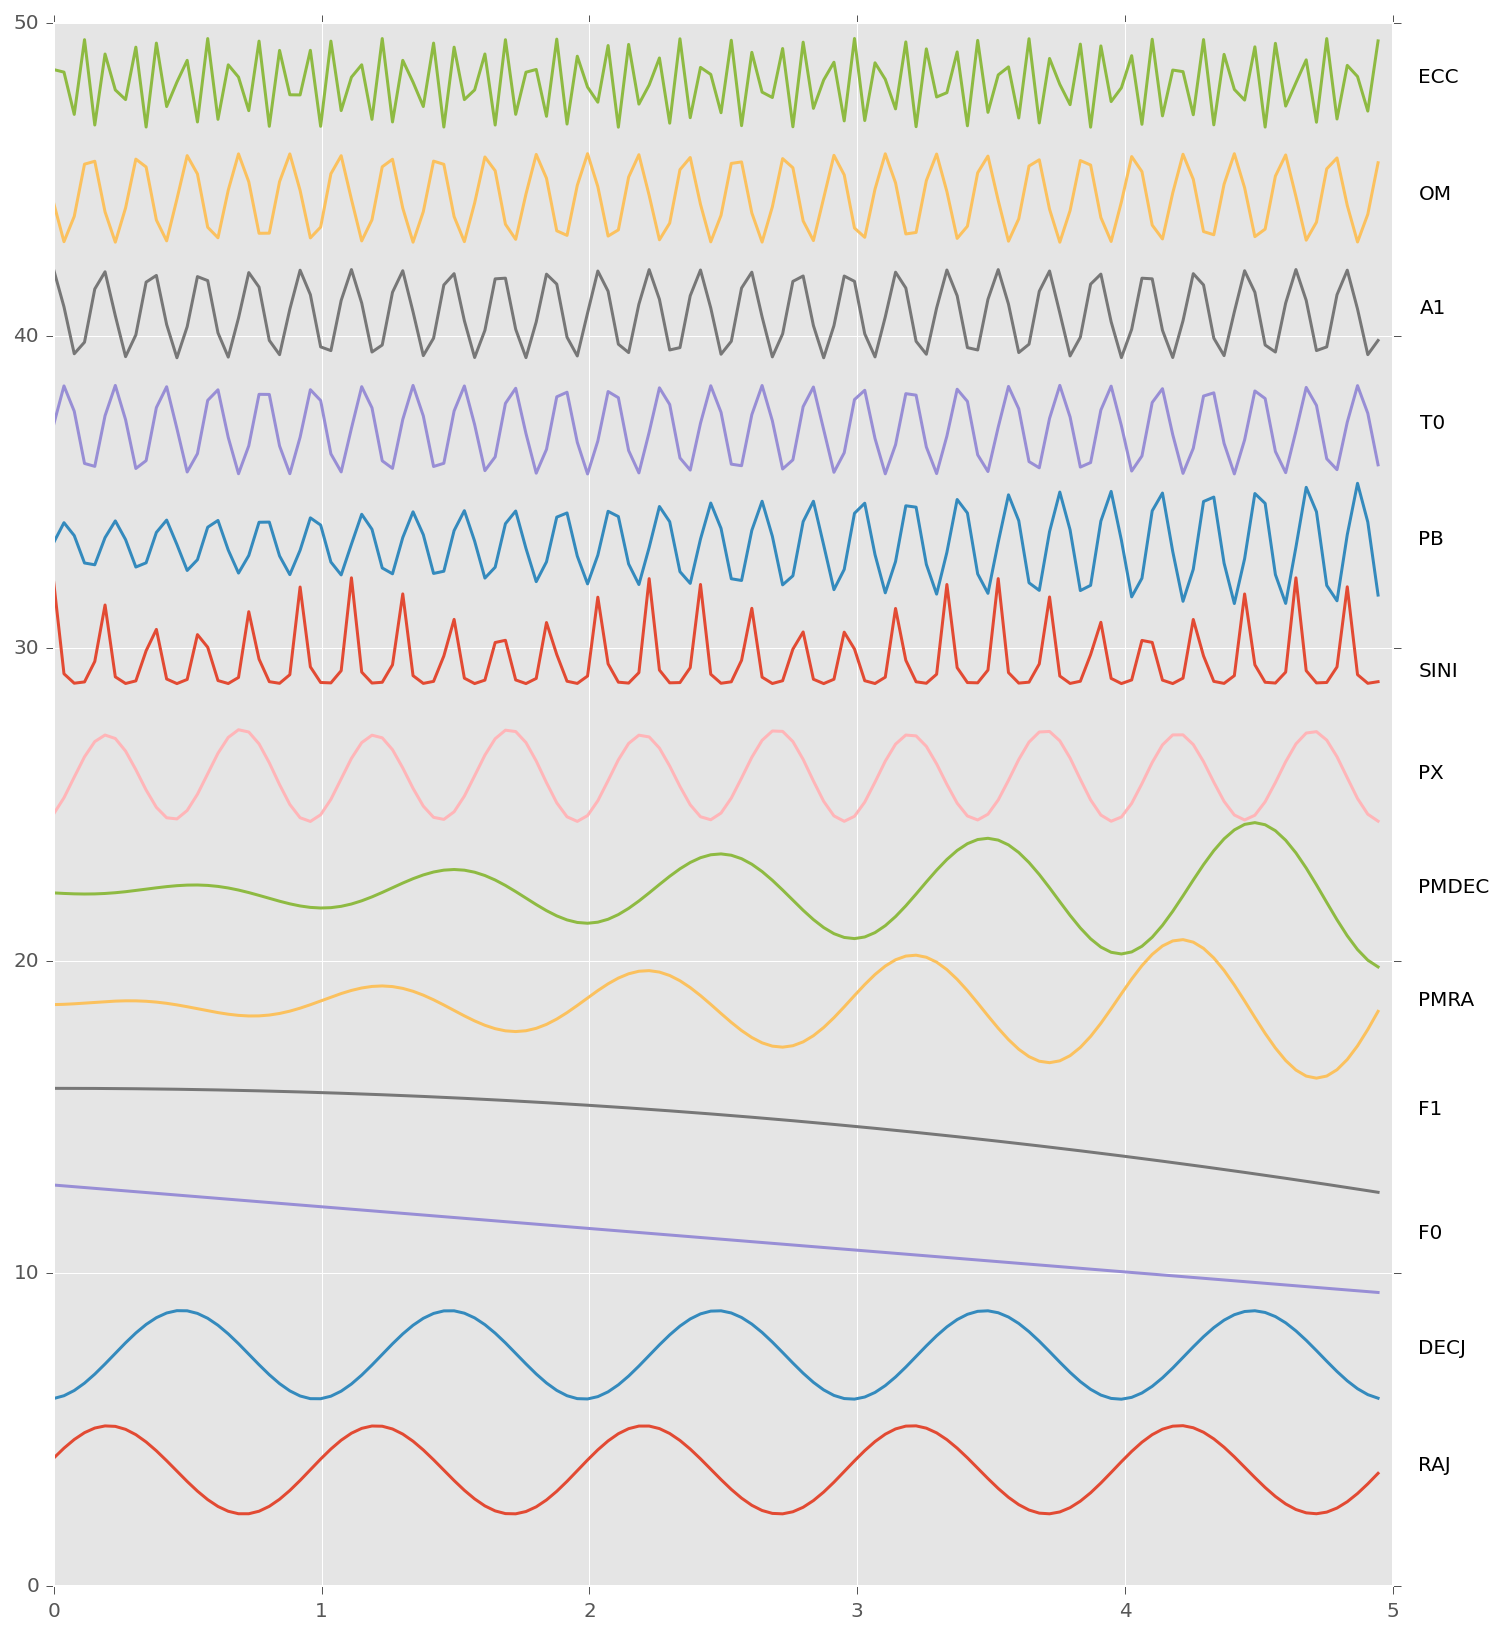

In [2]:
psr = t2.tempopulsar('/Users/jaellis/Work/pulsars/ipta_mdc/2012/IPTA_Challenge1_open/Challenge_Data/Dataset1/J1713+0747.par', 
                     '/Users/jaellis/Work/pulsars/ipta_mdc/2012/IPTA_Challenge1_open/Challenge_Data/Dataset1/J1713+0747.tim')

M = psr.designmatrix()
M -= np.mean(M, axis=0)
M /= np.std(M, axis=0)

pars = psr.pars()
t = (psr.toas() - psr.toas().min()) / 365.25
plt.figure(figsize=(12,14))
for ii in range(1,14):
    tm = M[:,ii]
    plt.plot(t, tm+3.7*ii, lw=1.5)
    plt.text(5.1, np.median(tm+3.7*ii), str(pars[ii-1]))

Here we have some feel for what the timing model basis functions look like in the time domain. Many are periodic in nature with slightly different phases and amplitude modulation.

## 1.2 Red noise

Many of our pulsars show some evidence or low frequency autoregressive noise. We usually call this red noise since it can be described by a power-law like power spectrum. To model the red noise we use Fourier features. In other words we model red noise as a Fourier series at specified frequencies. Since we are only interested in the low-frequency part of the spectrum we can get away with only choosing the lowest frequencies instead of modeling the full Nyquist range.

We write the red noise as 

$$\tau^{\rm RN} = \sum_{j=1}^{N^{\rm mode}}\left [ a_j \sin\left( \frac{2\pi j t}{T}\right) + b_j \cos\left( \frac{2\pi j t}{T}\right) \right] = F_{\rm red}a_{\rm red},$$

where $a_{\rm red}$ is a vector of the alternating sine and cosine amplitudes, $T$ is the total time span of the data, and $F_{\rm red}$ is a $N_{\rm TOA} \times 2N^{\rm mode}$ matrix with alternating sine and cosine terms with $N_{\rm mode}$ the number of frequencies used. Typically we use ~50 Fourier modes. 

Normally red noise is specified by a covariance matrix with non-zero diagonal elements. We can actually recover that here by computing the expectation value

$$\langle \tau^{\rm RN} (\tau^{\rm RN})^T \rangle = \int_{-T/2}^{T/2} \sum_{j=1}^{N^{\rm mode}}\sum_{i=1}^{N^{\rm mode}}\left [ a_j \sin\left( \frac{2\pi j t}{T}\right) + b_j \cos\left( \frac{2\pi j t}{T}\right) \right] \left [ a_i \sin\left( \frac{2\pi i t}{T}\right) + b_i \cos\left( \frac{2\pi i t}{T}\right) \right] dt = F_{\rm red}\langle a_{\rm red}a_{\rm red}^T \rangle F_{\rm red}^T$$

Notice that $\langle a_{\rm red}a_{\rm red}^T \rangle$ is a matrix with zero off-diagonal elements and a diagonal that is represented by the power spectrum $P(f)$. This way we can choose a model for the power spectrum and construct a covariance matrix

$$K_{\rm red} = F_{\rm red}\varphi F_{\rm red}^T$$,

where $\varphi_{i,i} = P(f_i)$, with $i$ the frequency mode index.

Here are a few realizations of processes that follow this formalism. 

We also plot the ACF and PACF of these processes for reference.

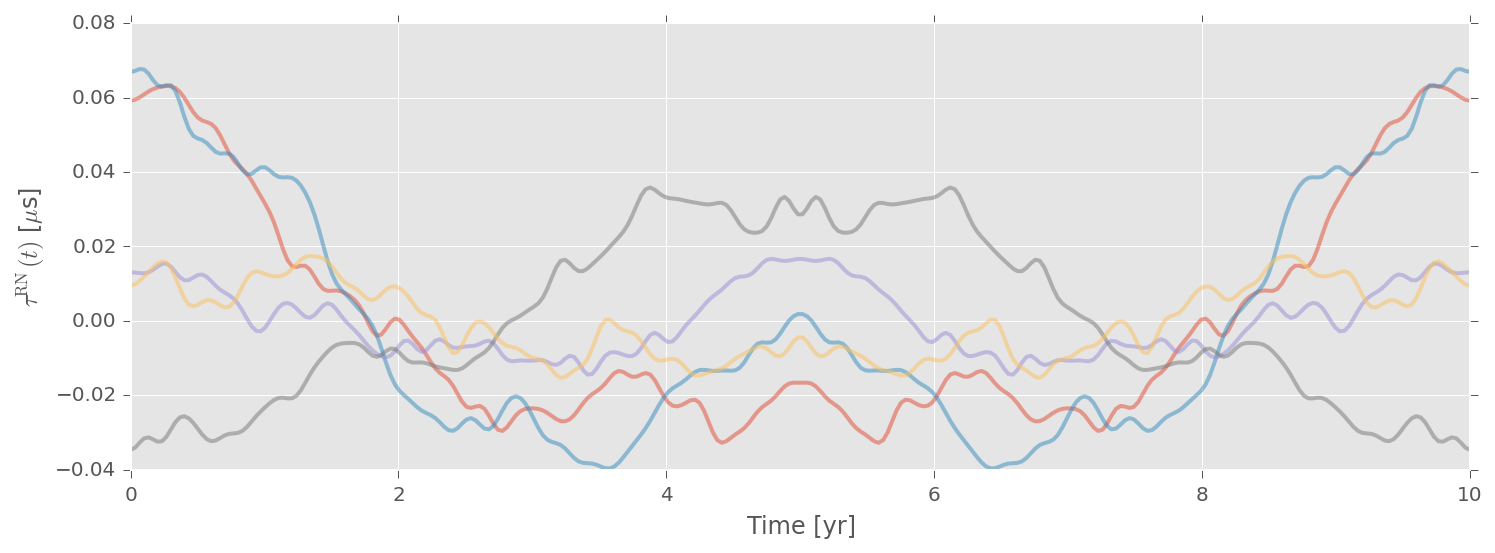

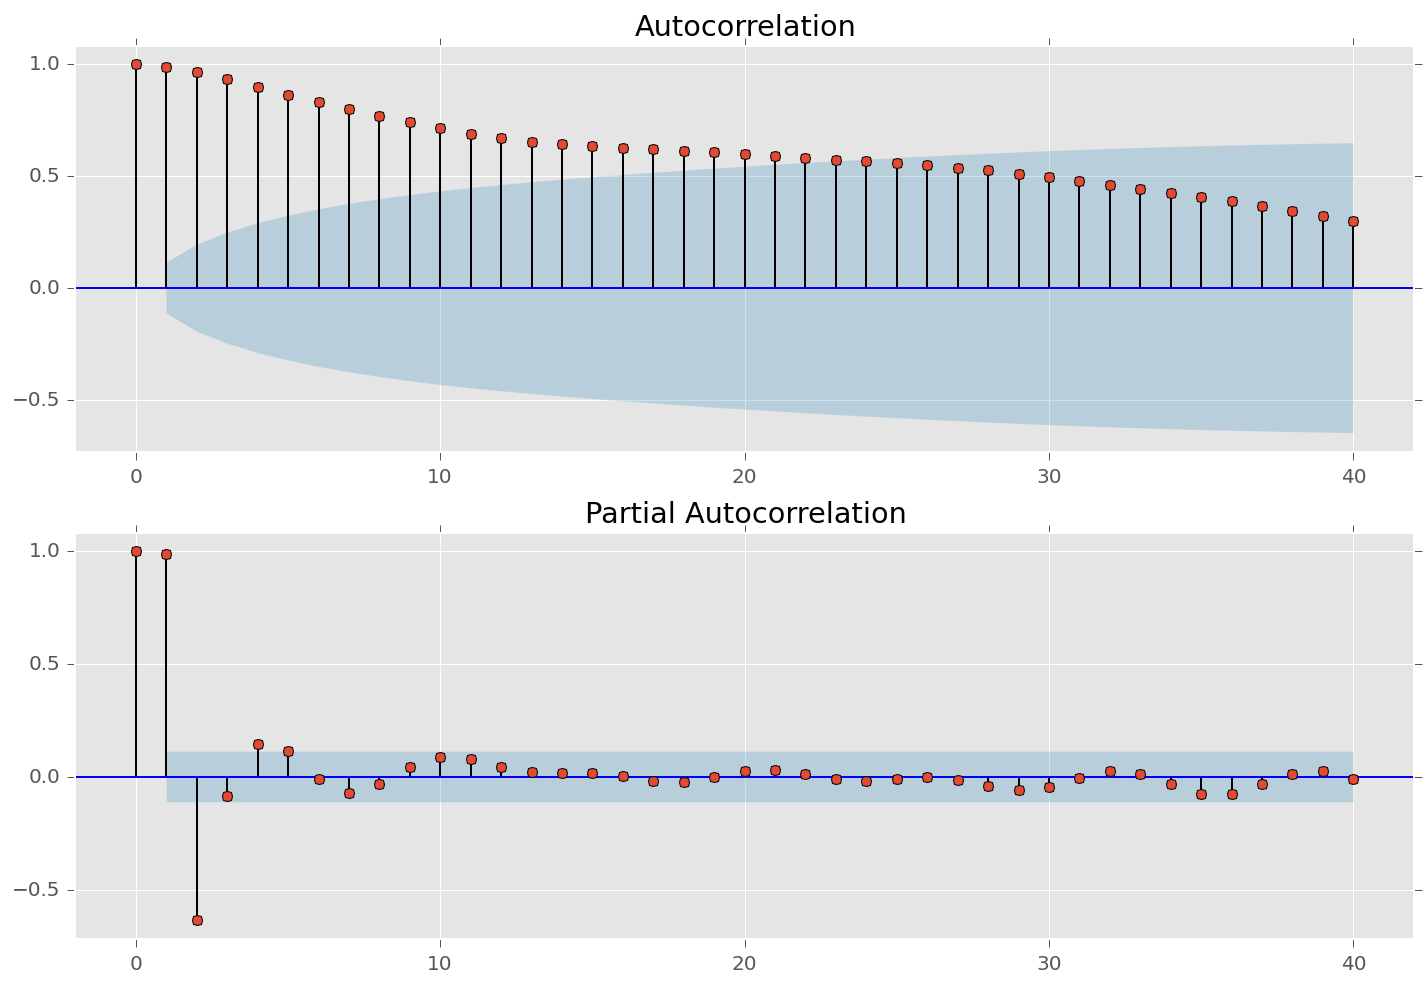

In [29]:
def create_fourier_designmatrix(t, nmode=50):
    
    # initialize
    F = np.zeros((len(t), 2*nmode))
    
    # set total time
    T = (t.max()-t.min())
    
    # fourier spaced frequencies
    f = np.linspace(1/T, nmode/T, nmode)
    
    F[:,::2] = np.cos(2*np.pi*t[:,None]*f[None,:])
    F[:,1::2] = np.cos(2*np.pi*t[:,None]*f[None,:])
    
    return f, F

def create_pl_matrix(A, gamma, f, T):
    
    # normalization
    f1yr = 1 / 3.16e7
    
    Pf = A**2 / 12 / np.pi ** 2 * f1yr ** (gamma - 3) * f**(-gamma) / T
    
    return np.repeat(Pf, 2)

### now create some red noise ###

# time samples (10 years)
t = np.linspace(0, 10, 300) * 3.16e7
T = t.max() - t.min()

# Fourier matrix and sample frequencies
f, F = create_fourier_designmatrix(t)

# create power spectrum
A = 1e-15
gamma = 2.5
phi = create_pl_matrix(A, gamma, f, T)

# create 5 realizations of noise from this process
plt.figure(figsize=(12,4))
for ii in range(5):
    w = np.random.randn(2*len(f))
    red = np.dot(F, np.sqrt(phi)*w)
    plt.plot(t/3.16e7, red*1e6, alpha=0.5, lw=2)
    
plt.xlabel('Time [yr]')
plt.ylabel(r'$\tau^{\rm RN}(t)$ [$\mu$s]')

# plot ACF and PACF of one realization
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(red, lags=40, ax=ax1, )
ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(red, lags=40, ax=ax2)

## 1.2 Dispersion measure variations

Dispersion measure is due to the propagation of radio waves through the charged plasma of the interstellar medium (ISM). In the general the dispersion measure is the integrated column density of electrons

$${\rm DM} = \int_0^L n_e d\ell,$$

however, in reality the electron density isn't constant through space and the distance and line of sight to a pulsar is not constant, so in reality we have

$${\rm DM}(t) \int_0^{L(t)} n_e(\mathbf{x})d\ell.$$

From this we can expect a stochastic component due to the density profile of $n_e(\mathbf{x})$ and a more secular component due to the pulsar's proper motion and radial velocity. 

In general we model this time varying dispersion measure in two ways. The first is to model it as a piecwise function where we fit a constant DM at each observing epoch and the second way is to model the secular variations with a quadratic and low frequency terms with the same Fourier features as for red noise (both with a $1/\nu^2$ radio frequency dependence).

For the piecewise model we can accomodate the notation that we have used thus far by defining

$$\tau^{\rm DM} = Dx,$$ 

where

$$
\begin{equation}
D = K
\begin{bmatrix}
\nu_1^{-2} & 0 & \\
\nu_2^{-2} & 0 & \\
\vdots & 0 & \dots \\
\nu_i^{-2} & 0 & \\
0 & \nu_{i+1}^{-2} & \\
0 & \nu_{i+2}^{-2} & \\
0 & \vdots & \dots \\
0 & \nu_{i+k}^{-2} & \\
\vdots & \vdots & \dots\\
\end{bmatrix},
\end{equation}
$$

with $x$ the values of DM at each epoch and $K$ is simply a scale factor to convert units of DM per $\nu^2$ to units of time. The matrix $D$ maps TOAs within an observing epoch (usually defined to be 14 days) to a timeseries with a single DM. This method has the advantage of being simple; however it has several drawbacks including the fact that we must assume that there are no significant DM varitions over the bin size (14 days) and that we are also inherently assuming that the DM at each epoch is independent. The first assumption is strong but the second is almost certaintly wrong.

Our second model can be written as 

$$\tau^{\rm DM} = \delta_{0}X + \delta_{1}Xt+\delta_{2}Xt^{2} + \sum_{j=1}^{N^{\rm mode}}\left [ a_{DM,j} \sin\left( \frac{2\pi j t}{T}\right) X+ b_{DM,j} \cos\left( \frac{2\pi j t}{T}\right)X  \right] = M_{\rm DM}d_{\rm DM} + F_{\rm DM}a_{\rm DM},$$

where $X_i=\nu_i^{-2}$ and the Fourier design matrix, $F_{\rm DM}$ has now incorporated this term. Furthermore, $M_{\rm DM}$ is a quadratic design matrix and $d_{\rm DM}$ is a vector of the amplitudes of the quadratic.

As with the red noise the stochastic component has covariance matrix 

$$K_{\rm DM} = F_{\rm DM}\langle a_{\rm DM} a_{\rm DM}^T  \rangle F_{\rm DM}^T = F_{\rm DM}\varphi_{\rm DM} F_{\rm DM}^T$$,

With $\varphi_{\rm DM}$ again the power spectrm of the $DM$ varitions in DM space.


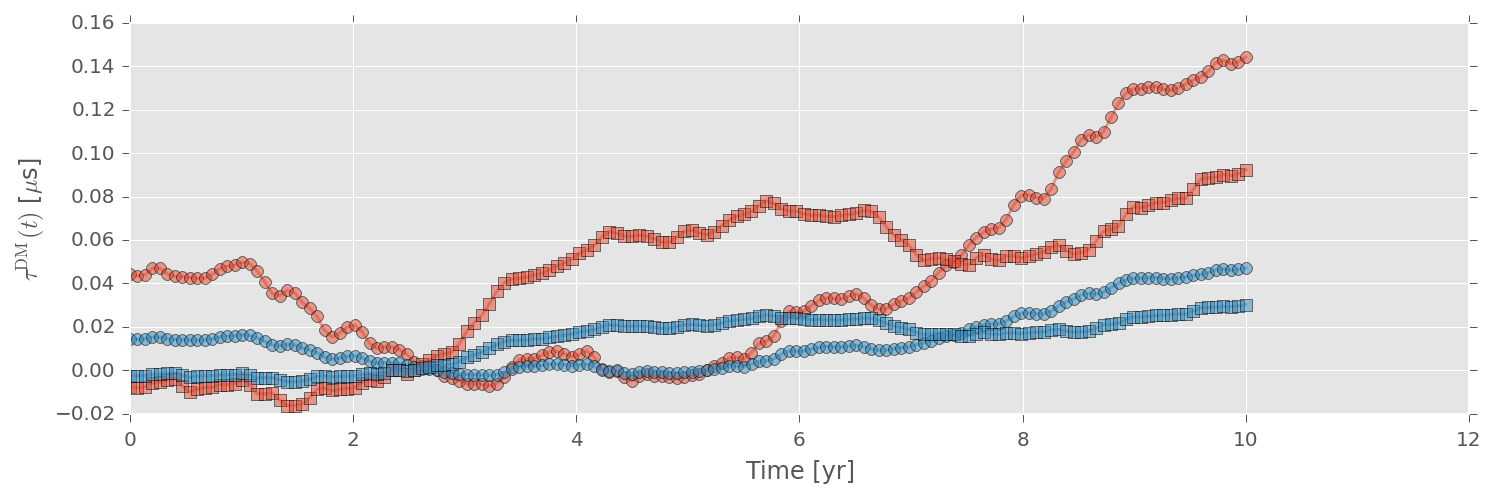

In [4]:
# simulate some frequencies and some TOAs
nu = np.concatenate((np.ones(150) * 800e6, np.ones(150) * 1400e6))
t = np.concatenate((np.linspace(0, 10, 150)*3.16e7, np.linspace(0, 10, 150)*3.16e7+3600))

# for simplicity lets normalize X to the lowest frequency
X = (800e6/nu)**2

# lets construct M_DM
M = np.column_stack((X, X*t, X*t**2))

# I want the overall effect of the secular terms to be about 100 ns
mvals = np.max(M, axis=0)
d = 0.5e-7/mvals

# remove the overall mean
d[0] = 0

# now construct the stochastic part
# Fourier matrix and sample frequencies
f, F = create_fourier_designmatrix(t)
F *= X[:, None]

# create power spectrum
A = 1e-15
gamma = 2.5
phi = create_pl_matrix(A, gamma, f, T)

# create some realizations
colors = plt.rcParams['axes.color_cycle'][:2]
markers = ['o', 's']
fig = plt.figure(figsize=(12,3.5))
for ii in range(2):
    w = np.random.randn(2*len(f))
    red = np.dot(M, d) + np.dot(F, np.sqrt(phi)*w)
    for ct, freq in enumerate(np.unique(nu)):
        ind = nu == freq
        plt.plot(t[ind]/3.16e7, red[ind]*1e6, alpha=0.5, lw=1.5, marker=markers[ii], color=colors[ct])
        
plt.xlabel('Time [yr]')
plt.ylabel(r'$\tau^{\rm DM}(t)$ [$\mu$s]')

## 1.4 Short timescale correlated noise (ECORR)

Due to the way that data is taken for large bandwidth receivers and to model inadequecies (i.e. we don't have a good model for how the pulse profile varies across the frequency band) we end up with several different TOAs at near simultaneous times. Because of this, these TOAs are very correlated over these short timescales. We model this by constructing a block diagonal covariance matrix, but it can also be descibed in the basis picture as follows

$$\tau^{\rm EC} = Uj,$$

where

$$
\begin{equation}
U = 
\begin{bmatrix}
1 & 0 & \\
1 & 0 & \\
\vdots & 0 & \dots \\
1 & 0 & \\
0 & 1 & \\
0 & 1 & \\
0 & \vdots & \dots \\
0 & 1 & \\
\vdots & \vdots & \dots\\
\end{bmatrix},
\end{equation}
$$

which, in a similar way to the $D$ matrix above for DM maps TOAs on to their repective observing epochs and $j$ is an amplitude of their timing deviation. For simplicity we assume that the amplitude at each epoch $j$ is drawn from an overall gaussian distribution with a single variace $\sigma_J^2$. The covariance matrix for this process then is block diagonal with the form

$$K_{\rm EC} = UJU^T,$$

where $J={\rm diag}(\sigma_j)^2$.

Below we will create a realization of this noise process and show its covariance matrix.

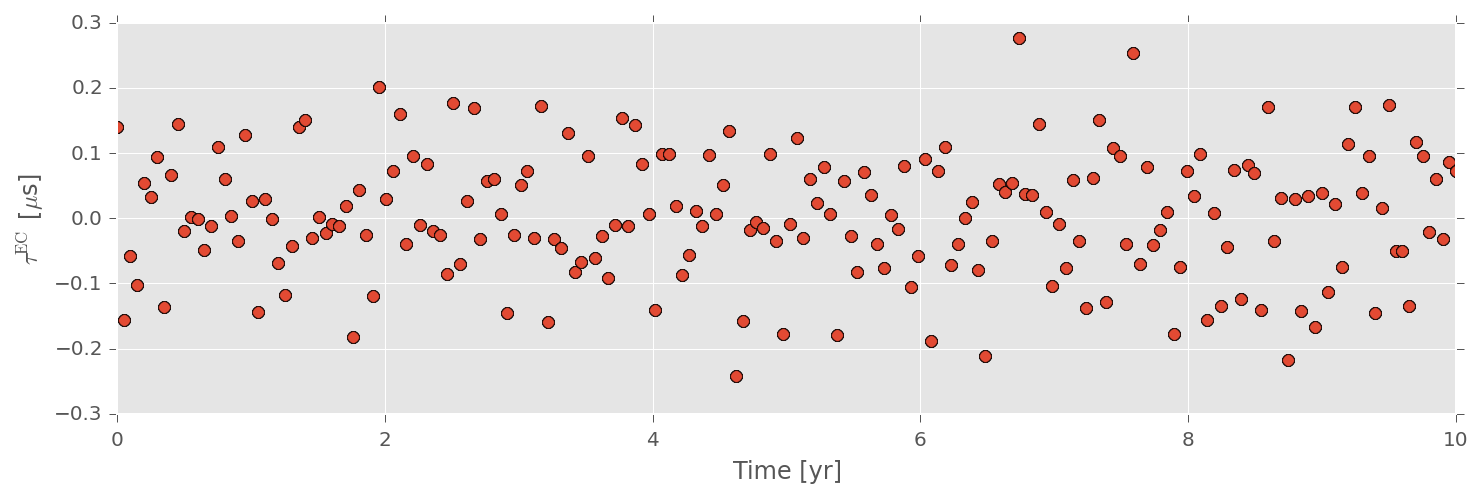

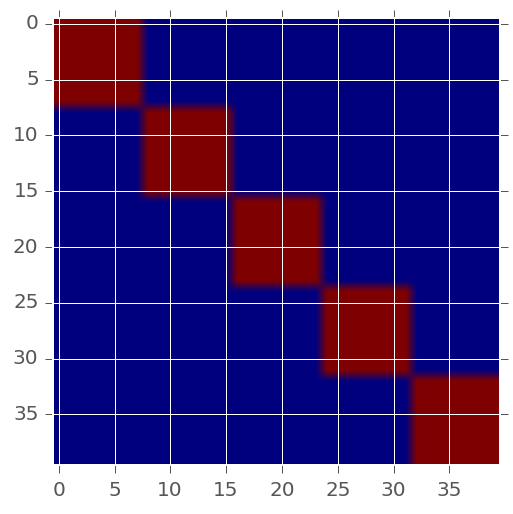

In [5]:
# function to define U matrix
def get_u_matrix(times, dt=1.0):
    isort = np.argsort(times)
    
    bucket_ref = [times[isort[0]]]
    bucket_ind = [[isort[0]]]
    
    for i in isort[1:]:
        if times[i] - bucket_ref[-1] < dt:
            bucket_ind[-1].append(i)
        else:
            bucket_ref.append(times[i])
            bucket_ind.append([i])
    
    avetoas = np.array([np.mean(times[l]) for l in bucket_ind],'d')
    
    U = np.zeros((len(times),len(bucket_ind)),'d')
    for i,l in enumerate(bucket_ind):
        U[l,i] = 1

    return avetoas, U

# lets define some TOAs with 200 epochs and 8 TOAs per epoch
tt = np.linspace(0, 10, 200) * 3.16e7
t = np.repeat(tt, 8)

# define U matrix
avetoas, U = get_u_matrix(t)

# lets look at a realization of ECORR
sigma_j = 1e-7
J = np.ones(U.shape[1]) * sigma_j**2
w = np.random.randn(len(J))
ec = np.dot(U, np.sqrt(J)*w)

fig = plt.figure(figsize=(12,3.5))
plt.plot(t/3.16e7, ec*1e6, 'o', alpha=0.5)

plt.xlabel('Time [yr]')
plt.ylabel(r'$\tau^{\rm EC}$ [$\mu$s]')

# plot covariance matrix for first 5 epochs
fig = plt.figure()
plt.imshow(np.dot(U, np.dot(np.diag(J), U.T))[:40,:40], interpolation=None)

Since we don't have any other white noise involved here this looks like simple white noise but remember all the points per epoch are completely correlated in this case. Next we will define the main contribution to the noise which is pure radiometer noise.

## 1.5 White noise 

For nearly all millisecond pulsars, the biggest contributor to the noise is white noise in the form of the measurement error. Unfortunately because of internal pulsar dynamics and the ISM we do not get the same pulse intensity for every observation, thus our data is very heteroscedasic.

Below is an example of pulsar scintillation which shows the intensity of the pulses as a function of time and radio frequency. This means that we can have very different measurement uncertainties at different radio frequencies and observation times.

![Pulsar Scintillation](img/mwa0437scintillation.gif)

In general we get the measurement uncertainties as part or the template fitting process; however, there can be other un-modelled white noise in our data as well. In that case we model an additional white noise term that is added in quadrature, so the overall white noise covariance matrix is 

$$N_{ij} = \delta_{ij}\left( \sigma_{\rm meas, ij}^2 + \sigma_{\rm equad, ij}^2\right),$$

where we usually call this extra white noise term EQUAD.

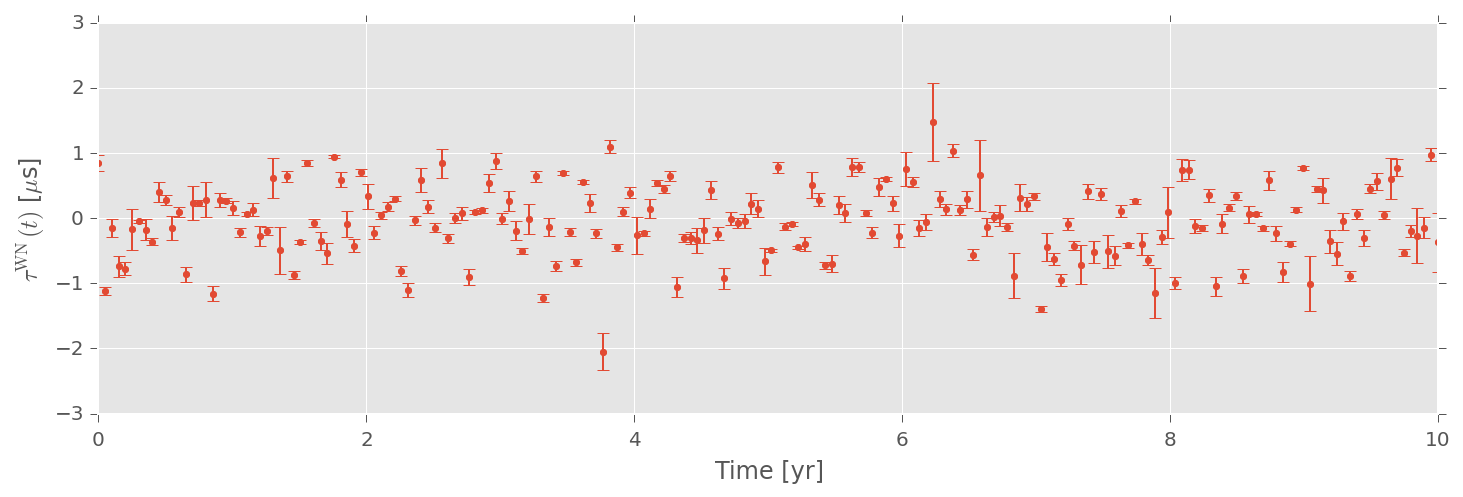

In [6]:
# lets simulate some TOAs
t = np.linspace(0, 10, 200) * 3.16e7

# lets assume some log-normal distribution for the measurement errors
sigma_meas = 10**(-7 + np.random.randn(len(t))*0.3)

# now lets add some equad at 500 ns
sigma_eq = 5e-7

# total sigma
sigma = np.sqrt(sigma_meas**2 + sigma_eq**2)

# make some data
data = np.random.randn(len(t))*sigma

fig = plt.figure(figsize=(12,3.5))
plt.errorbar(t/3.16e7, data*1e6, sigma_meas*1e6, fmt='.')
plt.xlabel('Time [yr]')
plt.ylabel(r'$\tau^{\rm WN}(t)$ [$\mu$s]')

Here we notice that the measurement uncertainties are much too small to account for the spread in the data.

## 1.6 Putting it all together

Now we will put all of this together and simulate some pulsar timing data

![](img/1937_resplot.png)
Above is an example of real pulsar timing data with strong red noise and DM variations.

It is important to remember that we use seperate EQUAD and ECORR parameters for every backend/observing frequency combination, in order to control for systematics between different systems

# 2 Gaussian process and likelihood model

Now that we have defined all of our noise terms, we will write down the likelihood function and go over some computational tricks to make it tractable.

First we will assume (and epmirical studies show this is a good assumption) that the measurement uncertainties are gaussian distributed with covariance matrix $N$. If we not write the residuals using the information above then we have

$$\delta \tau = M\epsilon + F_{\rm red}a_{\rm red} + M_{\rm DM}d_{\rm DM} + F_{\rm DM}a_{\rm DM} + Uj + n,$$

where $n$ is the white noise with $\langle n n^T\rangle=N$. 

There are two ways to think about the likelihood function, the Basis picture and the Kernel picture. In the Basis picture we explicitly model the residuals as above and then impose Gaussian priors on the amplitudes $\{ \epsilon, a_{\rm red}, d_{\rm DM}, a_{\rm DM}, j \}$. In the kernel picture we just model the residuals using the full covariance matrix defined by the white noise and these Gaussian priors. In the Bayesian sense, the Kernel comes from marginalizing the basis picture likelihood over the basis function amplitudes. 

Now we have shown that there are certain physical or statistical reasons to assume certain Gaussian priors on $\{ a_{\rm red}, a_{\rm DM}, j \}$; however, we have no such priors for the timing model or quadratic DM parameters and would like to use uniform priors. This can be accomodated by using Gaussian priors with infinite variance (it works!, you'll see). With that in mind let us simplify the notation as 

$$
T = [M\,\, F_{\rm red}\,\, M_{\rm DM}\,\, F_{\rm DM}\,\, U];
\quad\quad b = \begin{bmatrix} \epsilon \\ a_{\rm red} \\ d_{\rm DM} \\ a_{\rm DM} \\ j\end{bmatrix}
\quad \quad B = 
\begin{bmatrix}  
\infty & & & &\\
& \varphi & & & \\
& & \infty & & \\
& & & \varphi_{\rm DM} \\
& & & & J
\end{bmatrix}
$$

and the residuals and covariance matrix are now

$$\delta\tau = Tb + n$$
$$C = N + K = N + TBT^T$$

We define the vector of paramters that characterize the Gaussian priors (such as amplitude and spectral index of red noise or DM spectrum, and variance of ECORR) as $\phi$, so the matrix $B=B(\phi)$ and $N=N(\phi)$. In this case the likelihoods are

* Basis Picture:
$$ p(\delta\tau|b,\phi) = \frac{\exp{\bigg[-\frac{1}{2}(\delta\tau-Tb)^TN^{-1}(\delta\tau-Tb)\bigg]}}{\sqrt{ \det{2\pi N}}}\frac{\exp{\bigg[-\frac{1}{2}b^TB^{-1}b\bigg]}}{\sqrt{\det{2\pi B}}}$$

* Kernel Picture
$$p(\delta\tau|\phi)=\frac{\exp{\bigg[-\frac{1}{2}\delta\tau^T\left(N+K\right)^{-1}\delta\tau\bigg]}}{\sqrt{\det{2\pi(N+K)}}} $$

In the Kernel picture we use the Woodbury Lemma to compute the inverse and determinant of $(N+TBT^T)$

$$
\begin{split}
(N+TBT^T)^{-1} &= N^{-1} - N^{-1}T\left(B^{-1}+T^TN^{-1}T \right)^{-1}T^TN^{-1} \\
\det{(N+TBT^T)} &= \det{(N)}\det{(B)}\det{(B^{-1}+T^TN^{-1}T)}
\end{split}
$$

In case you were worried about our infinite variance trick notice that $\det{(B)} = 1/\det{(B^{-1})}$ and all other dependence on $B$ comes in the form of an inverse.

For a given pulsar and noise model $B$ may be a $1,000\times1,000$ matrix whereas the full covariance matrix (N+K) could be on the order of $30,000\times30,000$. This means that we cut the computation time by over a factor of 1000!
